In [1]:
import io
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from pylab import rcParams
from pandas import DataFrame
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot
from matplotlib import rc
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from pandas.plotting import register_matplotlib_converters
from sklearn.preprocessing import StandardScaler,RobustScaler # for standardizing the Data
from sklearn.decomposition import PCA

# Use seaborn style defaults and set the default figure size
sns.set(rc={'figure.figsize':(11, 4)})

In [2]:
covid19_csv = pd.read_csv('owid-covid-data.csv')
covid19_csv.head()

,iso_code,continent,location,date,total_cases,new_cases,new_cases_smoothed,total_deaths,new_deaths,new_deaths_smoothed,...,aged_70_older,gdp_per_capita,extreme_poverty,cardiovasc_death_rate,diabetes_prevalence,female_smokers,male_smokers,handwashing_facilities,hospital_beds_per_thousand,life_expectancy
0,AFG,Asia,Afghanistan,2019-12-31,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
1,AFG,Asia,Afghanistan,2020-01-01,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
2,AFG,Asia,Afghanistan,2020-01-02,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
3,AFG,Asia,Afghanistan,2020-01-03,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83
4,AFG,Asia,Afghanistan,2020-01-04,0.0,0.0,NaN,0.0,0.0,NaN,...,1.337,1803.987,NaN,597.029,9.59,NaN,NaN,37.746,0.5,64.83


In [3]:
covid19_df = covid19_csv[['location','date','total_cases','new_cases','total_deaths','new_deaths','population','population_density','aged_65_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','life_expectancy']]
covid19_df.head()

,location,date,total_cases,new_cases,total_deaths,new_deaths,population,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
0,Afghanistan,2019-12-31,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
1,Afghanistan,2020-01-01,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2,Afghanistan,2020-01-02,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
3,Afghanistan,2020-01-03,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
4,Afghanistan,2020-01-04,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83


In [4]:
# Converting the normally indexed dataframe to a time series indexed dataframe
covid19_df.index = pd.to_datetime(covid19_df['date'])
covid19_df = covid19_df.drop(columns=['date'])
covid19_df.head()

,location,total_cases,new_cases,total_deaths,new_deaths,population,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
date,,,,,,,,,,,,
2019-12-31,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-01,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-02,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-03,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83
2020-01-04,Afghanistan,0.0,0.0,0.0,0.0,38928341.0,54.422,2.581,1803.987,597.029,9.59,64.83


In [9]:
# Country dataframe creation

def country_dataset(country):

    grouped = covid19_df.groupby(covid19_df.location)
    df_country = grouped.get_group(country)
    df_country = df_country.dropna()
    df_country = df_country[df_country.total_cases != 0]
    df_country.head()
    
    return df_country
    
    ## df_all_selected_countries = covid19_df[covid19_df['location'].isin(['Canada','China','Italy','Mexico','Finland'])]
    ## df_all_selected_countries = pd.concat([df_all_selected_countries,pd.get_dummies(df_all_selected_countries['location'], prefix='country')],axis=1)
    ## df_all_selected_countries.drop(['location'],axis=1, inplace=True)
    ## df_all_selected_countries.head()

,location,total_cases,new_cases,total_deaths,new_deaths,population,population_density,aged_65_older,gdp_per_capita,cardiovasc_death_rate,diabetes_prevalence,life_expectancy
date,,,,,,,,,,,,
2020-02-29,Mexico,2.0,2.0,0.0,0.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05
2020-03-01,Mexico,4.0,2.0,0.0,0.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05
2020-03-02,Mexico,5.0,1.0,0.0,0.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05
2020-03-09,Mexico,7.0,2.0,0.0,0.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05
2020-03-12,Mexico,11.0,4.0,0.0,0.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05
...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-02,Mexico,606036.0,6476.0,65241.0,827.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05
2020-09-03,Mexico,610957.0,4921.0,65816.0,575.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05
2020-09-04,Mexico,616894.0,5937.0,66329.0,513.0,128932753.0,66.444,6.857,17336.469,152.783,13.06,75.05


In [6]:
def dim_red(df):
  df = df.dropna( axis=1, how="any", thresh=None, subset=None, inplace=False)
    
  X = df.values # getting all values as a matrix of dataframe 
  sc = StandardScaler() # creating a StandardScaler object
  X_std = sc.fit_transform(X) # standardizing the data

  #PCA
  pca = PCA()
  X_pca = pca.fit(X_std)
  plt.plot(np.cumsum(pca.explained_variance_ratio_))
  plt.xlabel('number of components')
  plt.ylabel('cumulative explained variance');
  plt.show()

  #Dimensionality Reduction
  num_components = 3
  pca = PCA(num_components)  
  X_pca = pca.fit_transform(X_std)
  pca = PCA(n_components = 0.9)
  X_pca = pca.fit_transform(X_std) # this will fit and reduce dimensions
  print(pca.n_components_) # one can print and see how many components are selected. In this case it is 4 same as above we saw in step 5
  pd.DataFrame(pca.components_, columns = df.columns)

  n_pcs = pca.n_components_ # get number of component
  # get the index of the most important feature on EACH component
  most_important = [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
  initial_feature_names = df.columns
  # get the most important feature names
  most_important_names = [initial_feature_names[most_important[i]] for i in range(n_pcs)]

  return most_important_names



In [7]:
#PCA Dimension reduction
important_parameters = dim_red(df_all_selected_countries)
print(important_parameters)

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 22, 10

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

NameError: name 'df_all_selected_countries' is not defined

In [10]:
def predict_new_deaths(df):
    
  train_size = int(len(df) * 0.9)
  test_size = len(df) - train_size
  train, test = df.iloc[0:train_size], df.iloc[train_size:len(df)]
  print(len(train), len(test))

  f_columns = ['total_cases','new_cases','total_deaths','new_deaths','population','population_density','aged_65_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','life_expectancy']

  f_transformer = RobustScaler()
  cnt_transformer = RobustScaler()

  f_transformer = f_transformer.fit(train[f_columns].to_numpy())
  cnt_transformer = cnt_transformer.fit(train[['new_deaths']])

  train.loc[:, f_columns] = f_transformer.transform(train[f_columns].to_numpy())
  train['cnt'] = cnt_transformer.transform(train[['new_deaths']])

  test.loc[:, f_columns] = f_transformer.transform(test[f_columns].to_numpy())
  test['cnt'] = cnt_transformer.transform(test[['new_deaths']])

  def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

  time_steps = 10

  # reshape to [samples, time_steps, n_features]

  X_train, y_train = create_dataset(train, train.cnt, time_steps)
  X_test, y_test = create_dataset(test, test.cnt, time_steps)

  model = keras.Sequential()
  model.add(
    keras.layers.Bidirectional(
      keras.layers.LSTM(
        units=128, 
        input_shape=(X_train.shape[1], X_train.shape[2])
      )
    )
  )
  model.add(keras.layers.Dropout(rate=0.2))
  model.add(keras.layers.Dense(units=1))
  model.compile(loss='mean_squared_error', optimizer='adam')

  history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=5, 
    validation_split=0.1,
    shuffle=False
  ) 

  y_pred = model.predict(X_test)

  y_train_inv = cnt_transformer.inverse_transform(y_train.reshape(1, -1))
  y_test_inv = cnt_transformer.inverse_transform(y_test.reshape(1, -1))
  y_pred_inv = cnt_transformer.inverse_transform(y_pred)

  plt.plot(history.history['loss'], label='train')
  plt.plot(history.history['val_loss'], label='test')
  plt.legend();
  plt.show()

  plt.plot(np.arange(0, len(y_train)), y_train_inv.flatten(), 'g', label="history")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_test_inv.flatten(), marker='.', label="true")
  plt.plot(np.arange(len(y_train), len(y_train) + len(y_test)), y_pred_inv.flatten(), 'r', label="prediction")
  plt.ylabel('Deaths per day')
  plt.xlabel('Time Step')
  plt.legend()
  plt.show();

In [11]:
def analyze(country):  

    print(country)
    df = country_dataset(country)
    
    df['total_cases'].plot()
    df['total_deaths'].plot()
    plt.show()
    df['new_cases'].plot()
    df['new_deaths'].plot()
    plt.show()
    #predict_daily_cases(df)
    #df = df[['population_density', 'aged_65_older', 'hospital_beds_per_100k', 'new_cases','new_deaths']]
    df = df[['total_cases','new_cases','total_deaths','new_deaths','population','population_density','aged_65_older','gdp_per_capita','cardiovasc_death_rate','diabetes_prevalence','life_expectancy']]
    predict_new_deaths(df)

Mexico


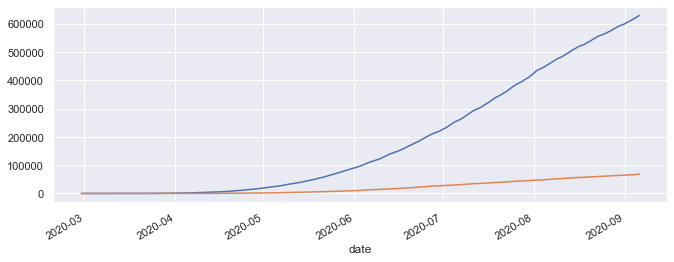

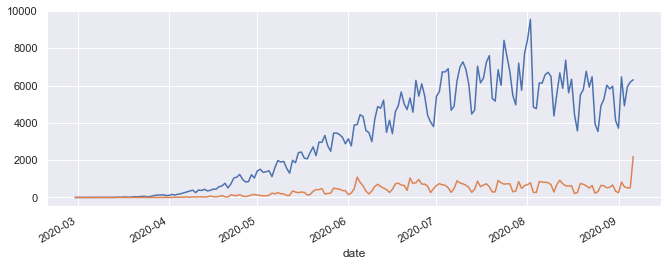

164 19


C:\Users\david\anaconda3\envs\py3-TF2\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
C:\Users\david\anaconda3\envs\py3-TF2\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\david\anaconda3\envs\py3-TF2\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pan

Epoch 1/100
28/28 [==============================] - 1s 35ms/step - loss: 0.0489 - val_loss: 0.0072
Epoch 2/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0107 - val_loss: 0.0015
Epoch 3/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0249 - val_loss: 0.0020
Epoch 4/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0334 - val_loss: 0.0396
Epoch 5/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0352 - val_loss: 7.4302e-04
Epoch 6/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0140 - val_loss: 0.0032
Epoch 7/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0122 - val_loss: 4.1346e-04
Epoch 8/100
28/28 [==============================] - 0s 7ms/step - loss: 0.0211 - val_loss: 0.0036
Epoch 9/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0096 - val_loss: 0.0016
Epoch 10/100
28/28 [==============================] - 0s 6ms/step - loss: 0.0127 - val_loss: 7.9485e

28/28 [==============================] - 0s 6ms/step - loss: 2.7766e-04 - val_loss: 8.8341e-05
Epoch 79/100
28/28 [==============================] - 0s 6ms/step - loss: 3.7054e-04 - val_loss: 3.2696e-05
Epoch 80/100
28/28 [==============================] - 0s 6ms/step - loss: 6.0019e-04 - val_loss: 2.1236e-04
Epoch 81/100
28/28 [==============================] - 0s 7ms/step - loss: 3.7922e-04 - val_loss: 5.9868e-05
Epoch 82/100
28/28 [==============================] - 0s 6ms/step - loss: 9.7638e-04 - val_loss: 4.8943e-05
Epoch 83/100
28/28 [==============================] - 0s 6ms/step - loss: 3.3925e-04 - val_loss: 1.0605e-04
Epoch 84/100
28/28 [==============================] - 0s 6ms/step - loss: 6.1974e-04 - val_loss: 3.2423e-05
Epoch 85/100
28/28 [==============================] - 0s 6ms/step - loss: 3.0671e-04 - val_loss: 1.4440e-04
Epoch 86/100
28/28 [==============================] - 0s 7ms/step - loss: 2.6855e-04 - val_loss: 4.8149e-04
Epoch 87/100
28/28 [=====================

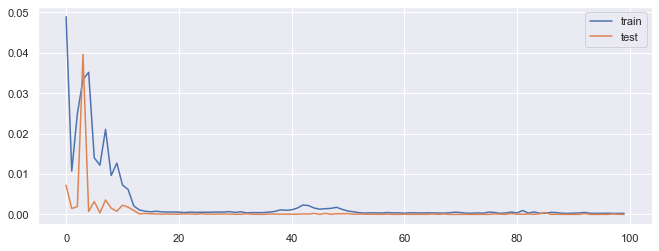

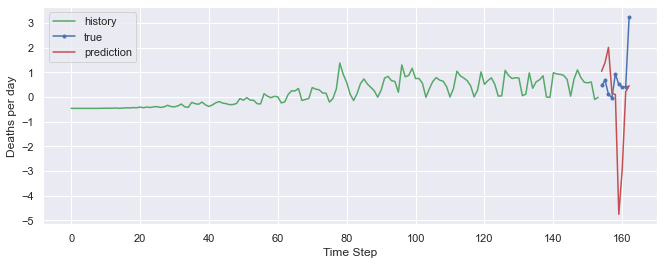

In [12]:
analyze("Mexico")